라이브러리

In [49]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise_distances
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 4
model_name = ['tank'+str(tank)+'_lstm_all', 'tank'+str(tank)+'_lstm_only-feed_no180', 'tank'+str(tank)+'_lstm_crop720_only-feed']

In [50]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [51]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

#문제 날짜 삭제
date_to_remove = pd.to_datetime('2021-08-03')
japonica_validation_data = japonica_validation_data.drop(japonica_validation_data[japonica_validation_data.index.date == date_to_remove.date()].index)

japonica_validation_features_X_a = japonica_validation_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

C:\Users\rladn\AppData\Local\Temp\ipykernel_19868\1114470494.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
C:\Users\rladn\AppData\Local\Temp\ipykernel_19868\1114470494.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
C:\Users\rladn\AppData\Local\Temp\ipykernel_19868\1114470494.py:2

In [52]:
japonica_validation_data.describe()

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
count,63360.0,63360.000000,63360.000000,63360.000000,63360.000000,63360.000000,63360.0,63360.000000,63360.000000,63360.000000
mean,4.0,8.651217,29.250451,5.238378,227.361035,28.771872,0.0,4.099834,0.015751,0.020477
std,0.0,2.077479,1.511900,0.515905,22.160425,8.131227,0.0,0.215156,0.472258,0.613935
min,4.0,1.500000,20.100000,3.970000,108.500000,0.000000,0.0,3.800000,0.000000,0.000000
25%,4.0,7.600000,28.800000,4.810000,214.200000,22.000000,0.0,4.000000,0.000000,0.000000
50%,4.0,8.700000,29.100000,5.250000,225.800000,31.500000,0.0,4.000000,0.000000,0.000000
75%,4.0,9.700000,30.500000,5.450000,239.000000,34.200000,0.0,4.100000,0.000000,0.000000
max,4.0,20.000000,31.700000,7.750000,369.000000,50.000000,0.0,5.700000,16.000000,20.800000


모델 평가

In [53]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva5(y_test, X_test_shape, feed):
    model = []
    array_index = 0
    
    for i in range(len(model_name)):
        model.append(load_model(model_name[i]+'.h5', custom_objects={'r_squared': r_squared}))
    
    X_pred1 = model[0].predict(X_test_shape)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))
    
    X_pred2_result_array = np.asarray(feed)
    X_pred2_result_array = X_pred2_result_array.reshape((-1, 1, 1))
    X_pred2_result = model[1].predict(X_pred2_result_array)
    X_pred2_result = np.asarray(X_pred2_result, dtype=np.float64)
    X_pred2_result = X_pred2_result.reshape((-1))

    X_pred3_result = np.ones(len(feed))
    X_pred4_result = np.ones(len(feed))

    #X_pred2_result_nomal = np.ones(len(feed))
    X_pred3_result_nomal = np.ones(len(feed))
    #X_pred4_result_nomal = np.ones(len(feed))

    for i in range(len(feed)):
        if feed[i] > 0 :
            nomal_array = np.asarray(0)
            nomal_array = nomal_array.reshape((-1, 1, 1))
            nomal = model[1].predict(nomal_array)
            nomal = np.asarray(nomal, dtype=np.float64)
            nomal = nomal.reshape((-1))

            array_index = i
            X_pred2_array = np.asarray(feed[i])
            X_pred2_array = X_pred2_array.reshape((-1, 1, 1))
            X_pred2 = model[1].predict(X_pred2_array)
            X_pred2 = np.asarray(X_pred2, dtype=np.float64)
            X_pred2 = X_pred2.reshape((-1))[0]

            #print(i)

            array_length = 720
            #X_pred2_ones = np.ones(array_length)
            #X_pred2_ones = np.asarray(X_pred2_ones, dtype=np.float64)
            #X_pred2_ones = X_pred2_ones * X_pred2
            
            X_pred3_array = np.zeros(array_length)
            X_pred3_array[270] = feed[i]
            X_pred3_array = X_pred3_array.reshape((-1, array_length, 1))
            X_pred3 = model[2].predict(X_pred3_array)
            X_pred3 = np.asarray(X_pred3, dtype=np.float64)
            X_pred3 = X_pred3.reshape((-1))

            X_pred4 = X_pred3 * X_pred2 / nomal

            #X_pred2_nomal = X_pred2_ones / nomal
            X_pred3_nomal = X_pred3 / nomal
            #X_pred4_nomal = X_pred4 / nomal


            x = 0
            if array_index < 270 :
                x = 270 - array_index
                #X_pred2_ones = X_pred2_ones[x:]
                X_pred3 = X_pred3[x:]
                X_pred4 = X_pred4[x:]
                #X_pred2_nomal = X_pred2_nomal[x:]
                X_pred3_nomal = X_pred3_nomal[x:]
                #X_pred4_nomal = X_pred4_nomal[x:]


            #X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2_ones)] = X_pred2_result[array_index+x-270:array_index-270+x+len(X_pred2_ones)] * X_pred2_ones
            X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] = X_pred3_result[array_index+x-270:array_index-270+x+len(X_pred3)] * X_pred3
            X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] = X_pred4_result[array_index+x-270:array_index-270+x+len(X_pred4)] * X_pred4
            #X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred2_nomal)] = X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred2_nomal)] * X_pred2_nomal
            X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] = X_pred3_result_nomal[array_index+x-270:array_index-270+x+len(X_pred3_nomal)] * X_pred3_nomal
            #X_pred4_result_nomal[array_index+x-270:array_index-270+x+len(X_pred4_nomal)] = X_pred2_result_nomal[array_index+x-270:array_index-270+x+len(X_pred4_nomal)] * X_pred4_nomal


    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank sensor do')
    plt.legend(['sensor do'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred2_result, color='red', label='prediction 2 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction 2 do','prediction 3 do','feed_quantity'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred3_result, color='red', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction 2 do','prediction 3 do','feed_quantity'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred3_result, color='red', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('do nomal grape')
    plt.legend(['do'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred3_result, color='red', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, X_pred2_result, color='orange', label='prediction 3 do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction 2 do','prediction 3 do','feed_quantity'])
    plt.show()

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, X_pred3_result_nomal, color='red', label='weight 3 do')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['weight 3 do'])
    plt.show()


    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred4_result, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank prediction do')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    #################################################

    final_predictions = X_pred1 * X_pred3_result_nomal
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

    y_test_reshape = np.asarray(y_test, dtype=np.float64)
    y_test_reshape = y_test_reshape.reshape((-1,1))

    # 유클리디안 거리 계산
    euclidean_distance1 = euclidean(y_test_reshape.flatten(), X_pred1.flatten())
    euclidean_distance2 = euclidean(y_test_reshape.flatten(), final_predictions.flatten())
    print("Euclidean Distance\n", f"{euclidean_distance1:.3f}" ," → ", f"{euclidean_distance2:.3f}")

    # 코사인 유사도 계산
    cosine_similarity1 = 1 - cosine(y_test_reshape.flatten(), X_pred1.flatten())
    cosine_similarity2 = 1 - cosine(y_test_reshape.flatten(), final_predictions.flatten())
    print("Cosine Similarity\n", f"{cosine_similarity1:.3f}" ," → ", f"{cosine_similarity2:.3f}")

    # 상관관계 계산
    correlation_coefficient1 = correlation(y_test_reshape.flatten(), X_pred1.flatten())
    correlation_coefficient2 = correlation(y_test_reshape.flatten(), final_predictions.flatten())
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")

    mse1 = mean_squared_error(y_test_reshape.flatten(), X_pred1.flatten())
    mse2 = mean_squared_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Squared Error\n", f"{mse1:.3f}" ," → ", f"{mse2:.3f}")

    # 평균 절대 오차 계산
    mae1 = mean_absolute_error(y_test_reshape.flatten(), X_pred1.flatten())
    mae2 = mean_absolute_error(y_test_reshape.flatten(), final_predictions.flatten())
    print("Mean Absolute Error\n", f"{mae1:.3f}" ," → ", f"{mae2:.3f}")

    # 상관관계 계산
    correlation_coefficient1 = np.corrcoef(y_test_reshape.flatten(), X_pred1.flatten())[0, 1]
    correlation_coefficient2 = np.corrcoef(y_test_reshape.flatten(), final_predictions.flatten())[0, 1]
    print("Correlation Coefficient\n", f"{correlation_coefficient1:.3f}" ," → ", f"{correlation_coefficient2:.3f}")

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='orange', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, final_predictions, color='red', label='final prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(str(tank) + 'tank final_predictions')
    plt.legend(['sensor do','prediction do','final predictions do','feed_quantity'])
    plt.show()

nCar: 61740 nVar: 1
nCar: 343 nVar: 9
nCar: 343 nVar: 9
1/1 [==============================] - 0s 99ms/step


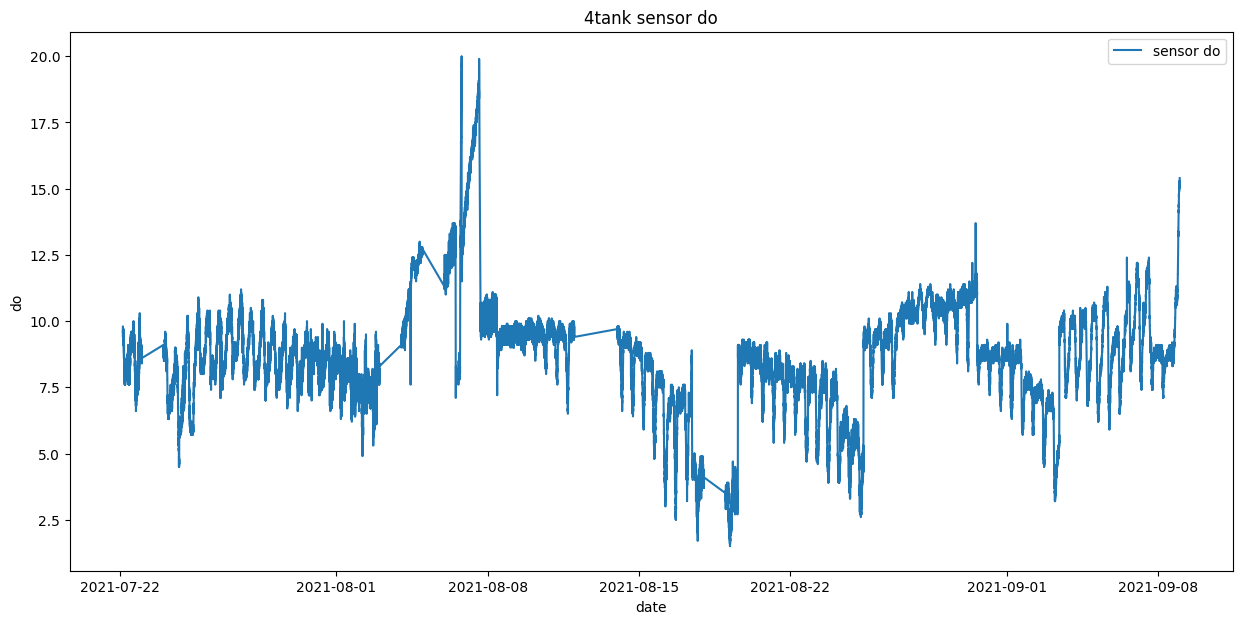

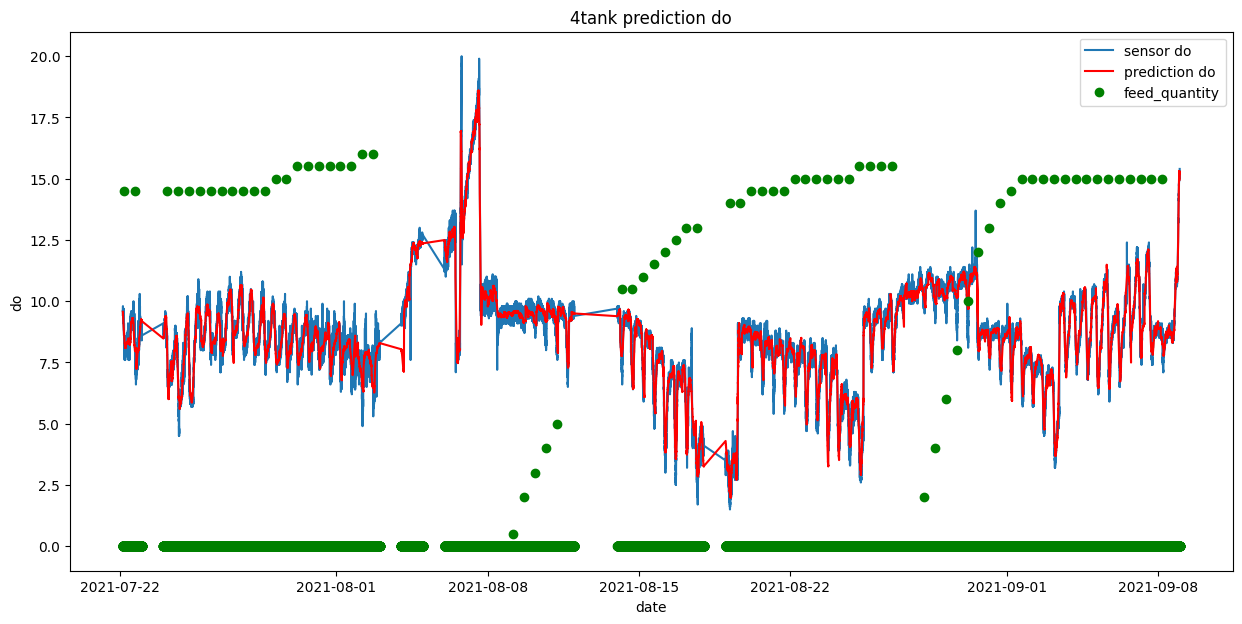

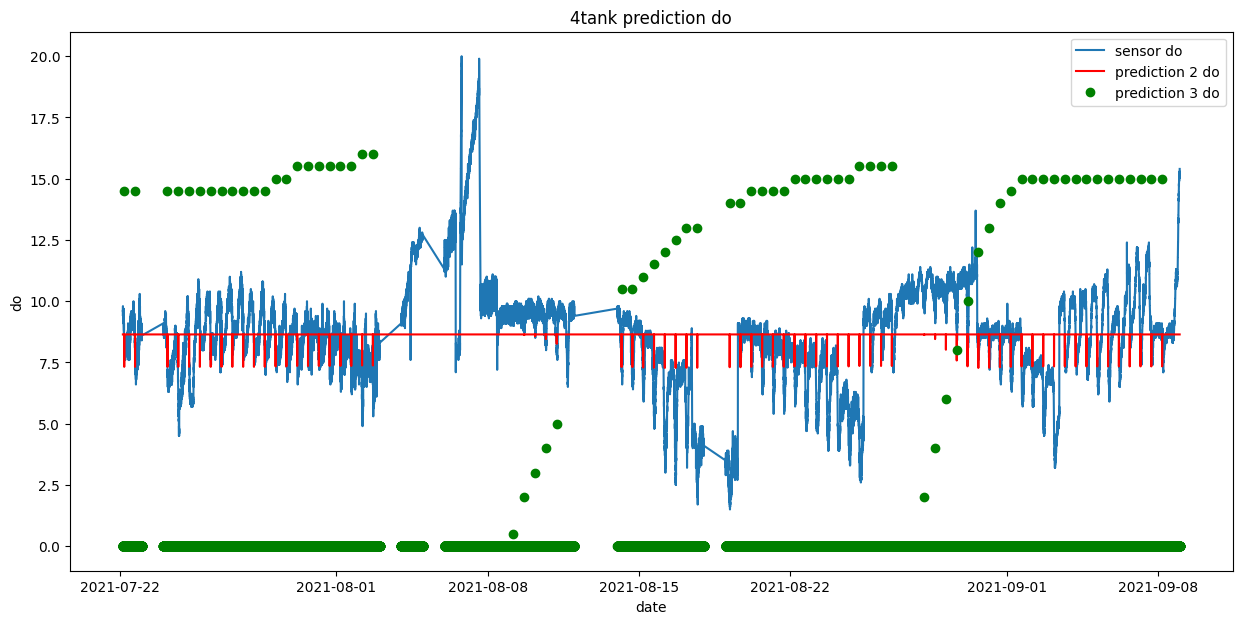

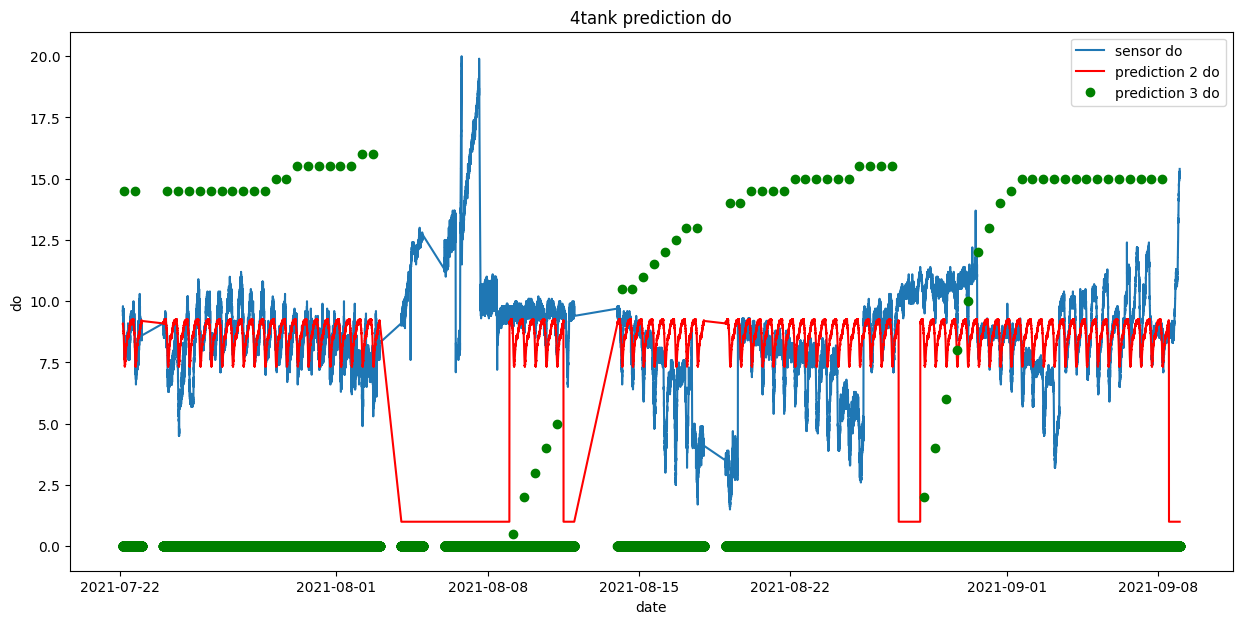

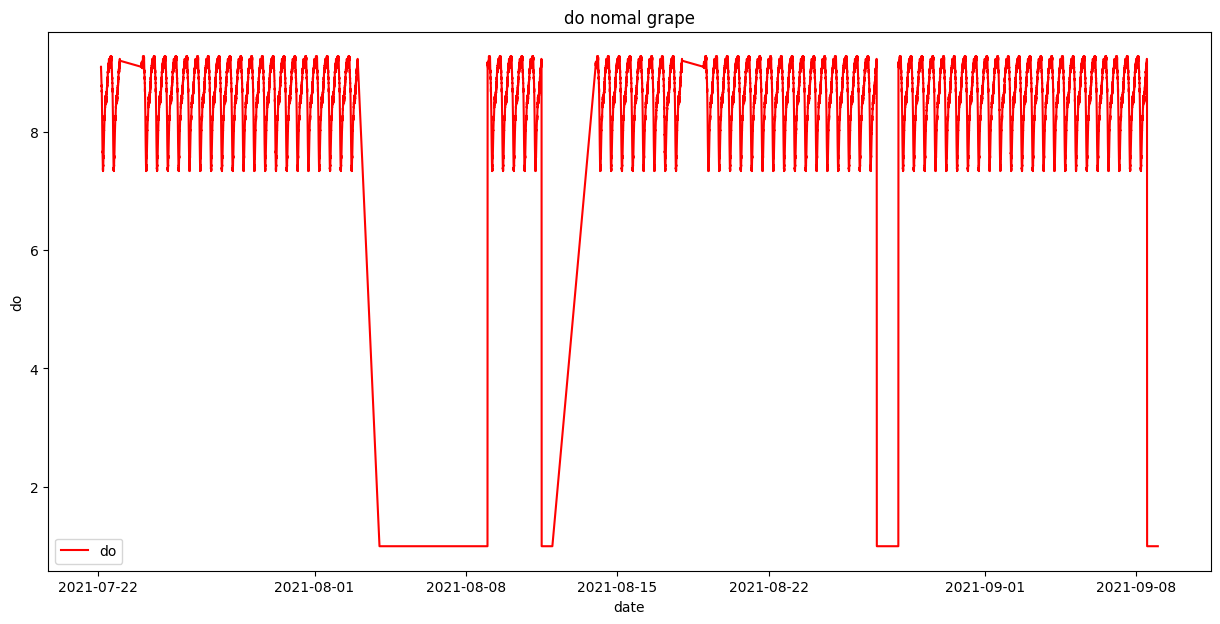

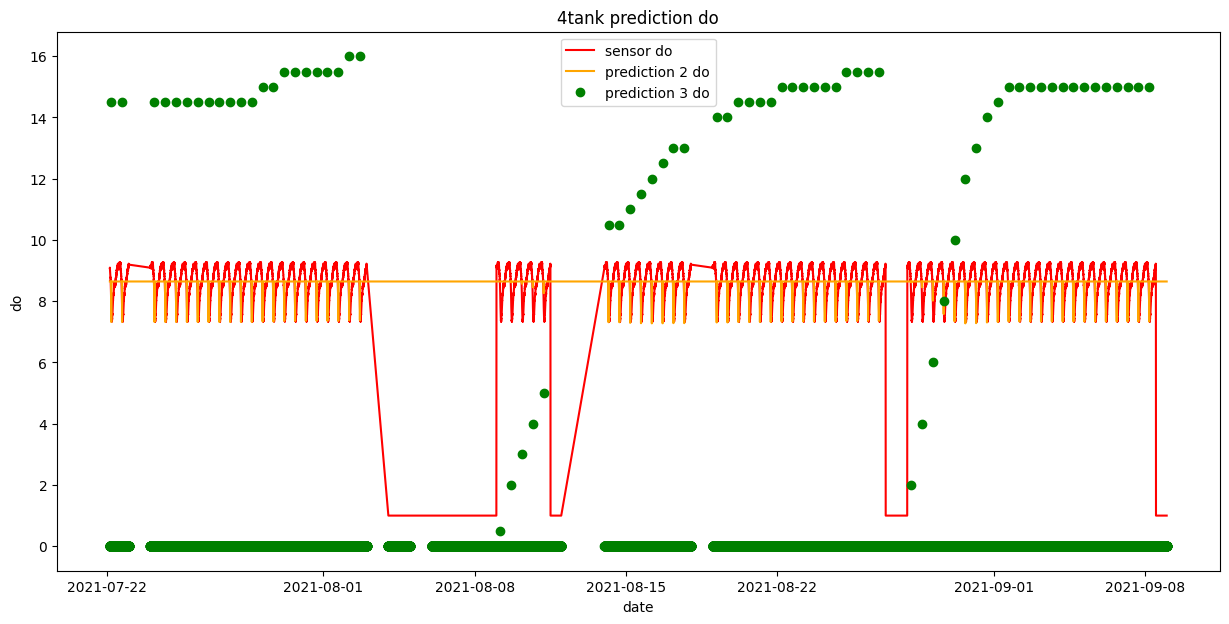

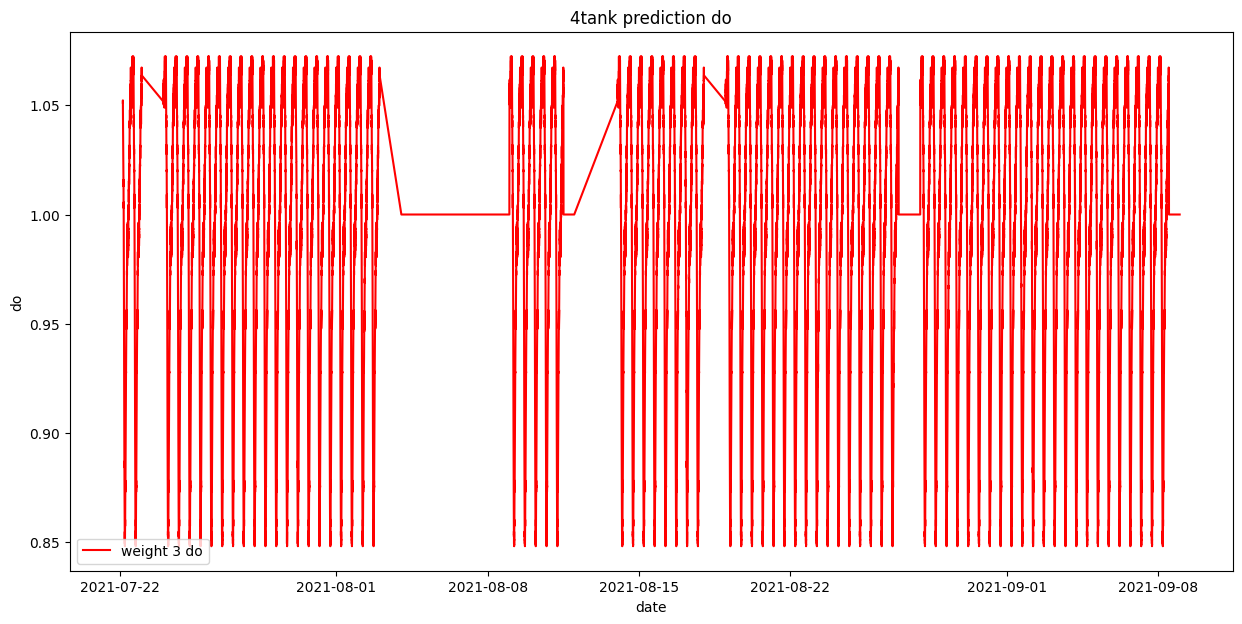

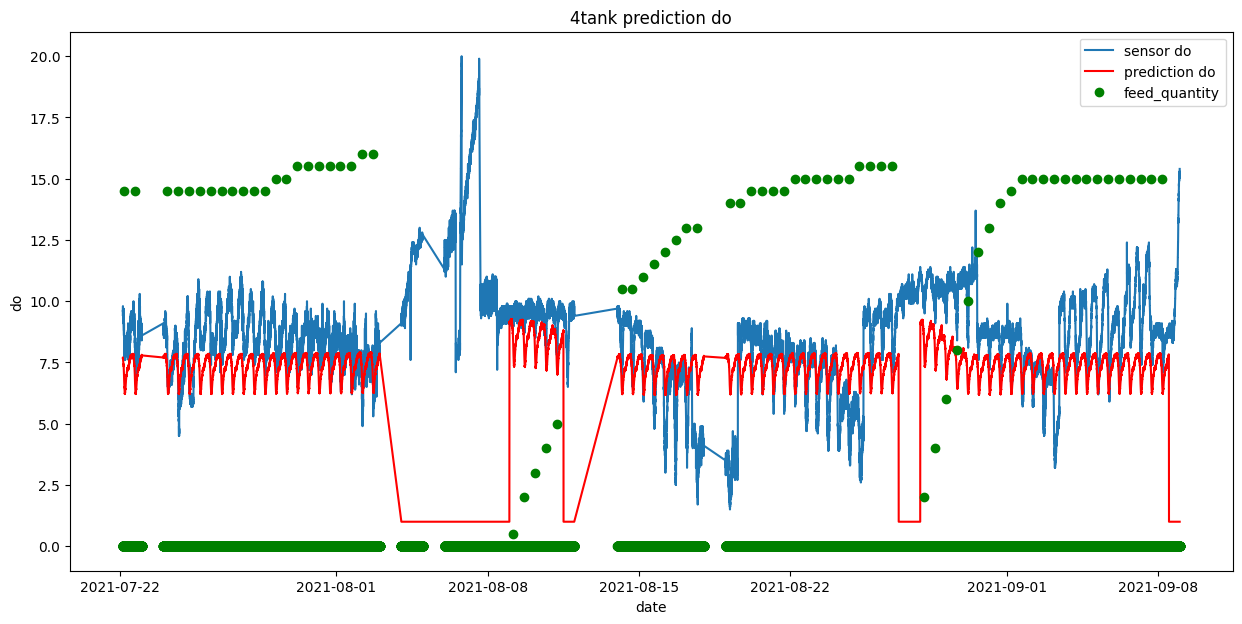

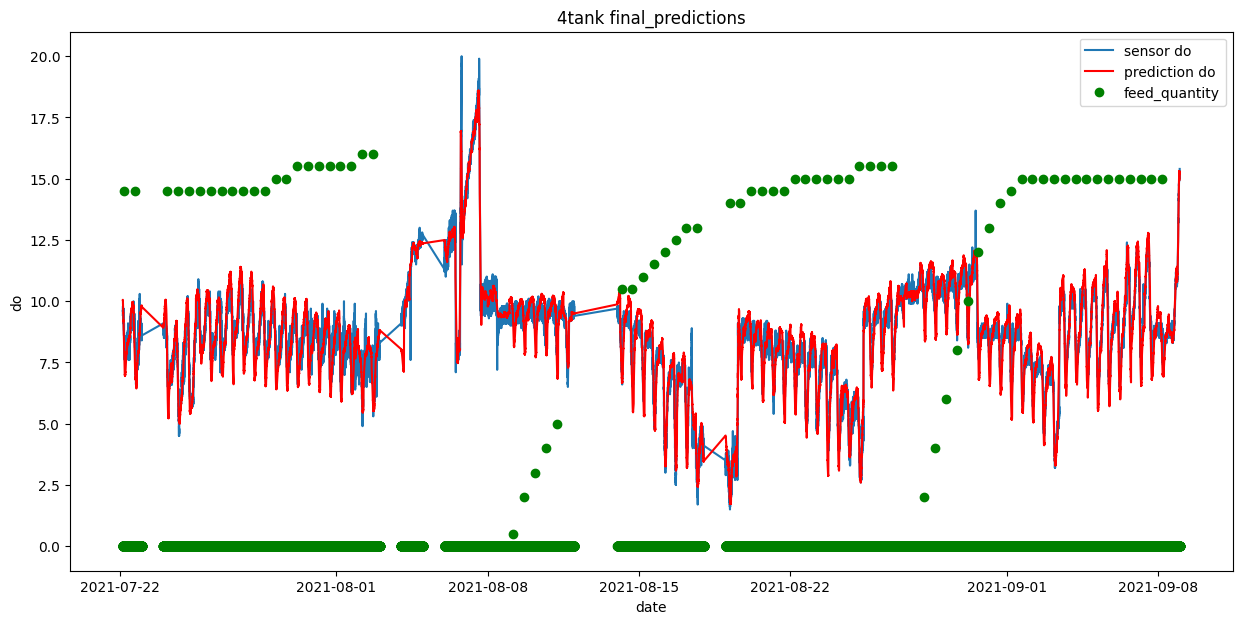

Euclidean Distance
 101.985  →  148.111
Cosine Similarity
 0.999  →  0.998
Correlation Coefficient
 0.019  →  0.037
Mean Squared Error
 0.168  →  0.355
Mean Absolute Error
 0.291  →  0.468
Correlation Coefficient
 0.981  →  0.963


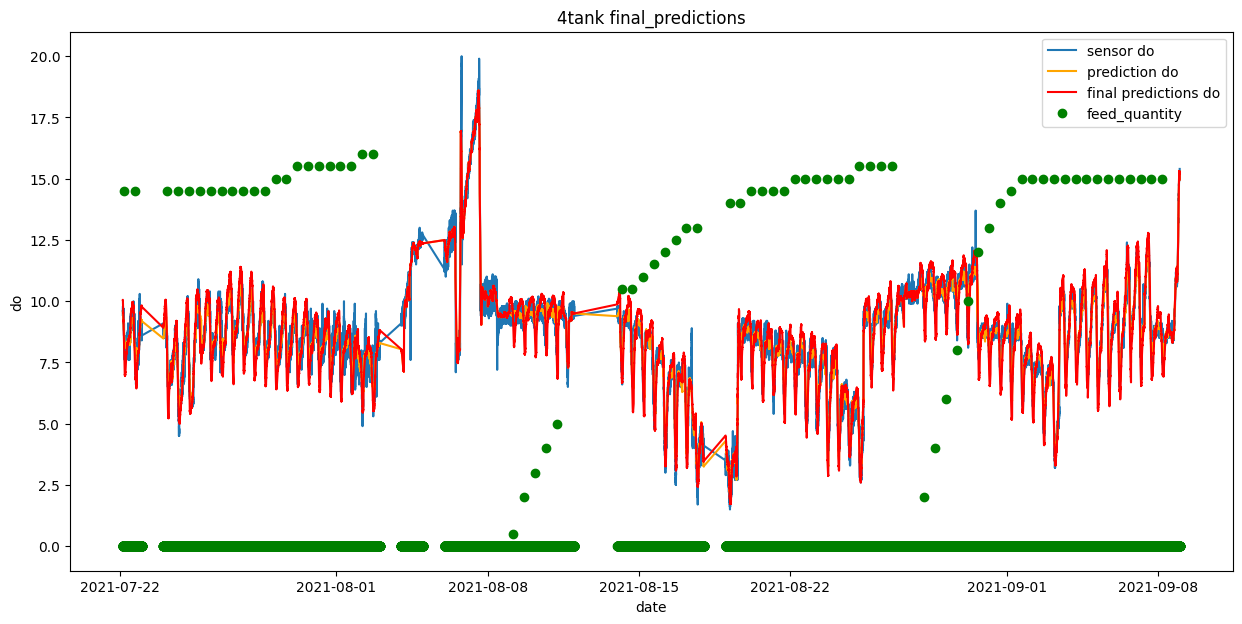

In [54]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 7020 nVar: 1
nCar: 39 nVar: 9
nCar: 39 nVar: 9
1/1 [==============================] - 0s 98ms/step


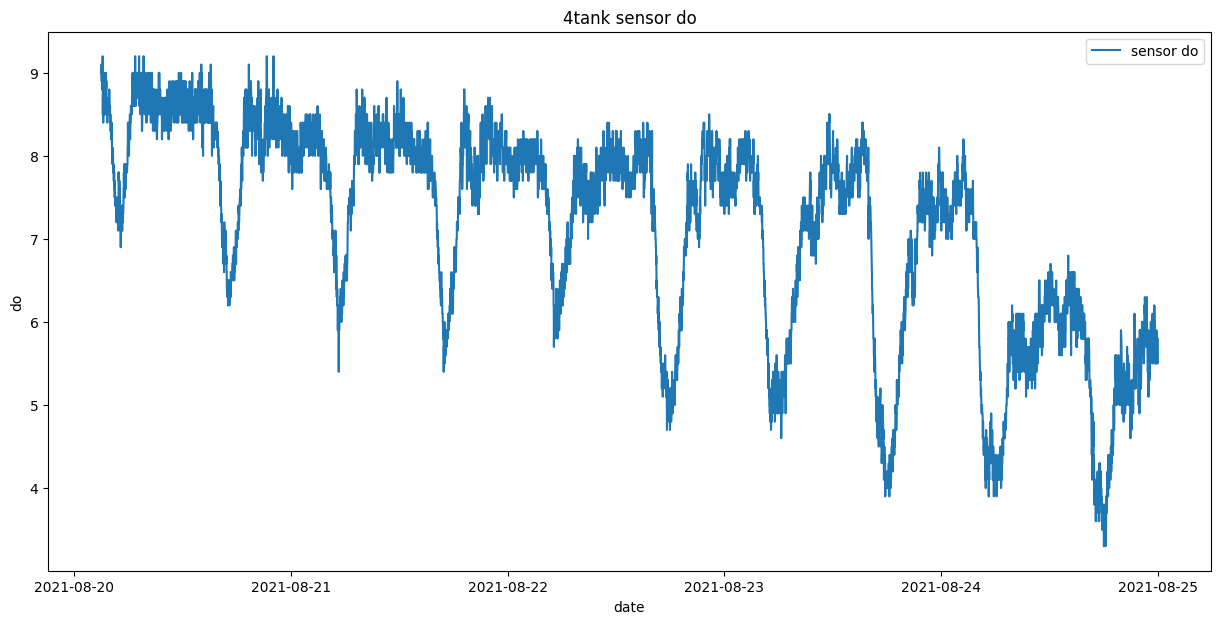

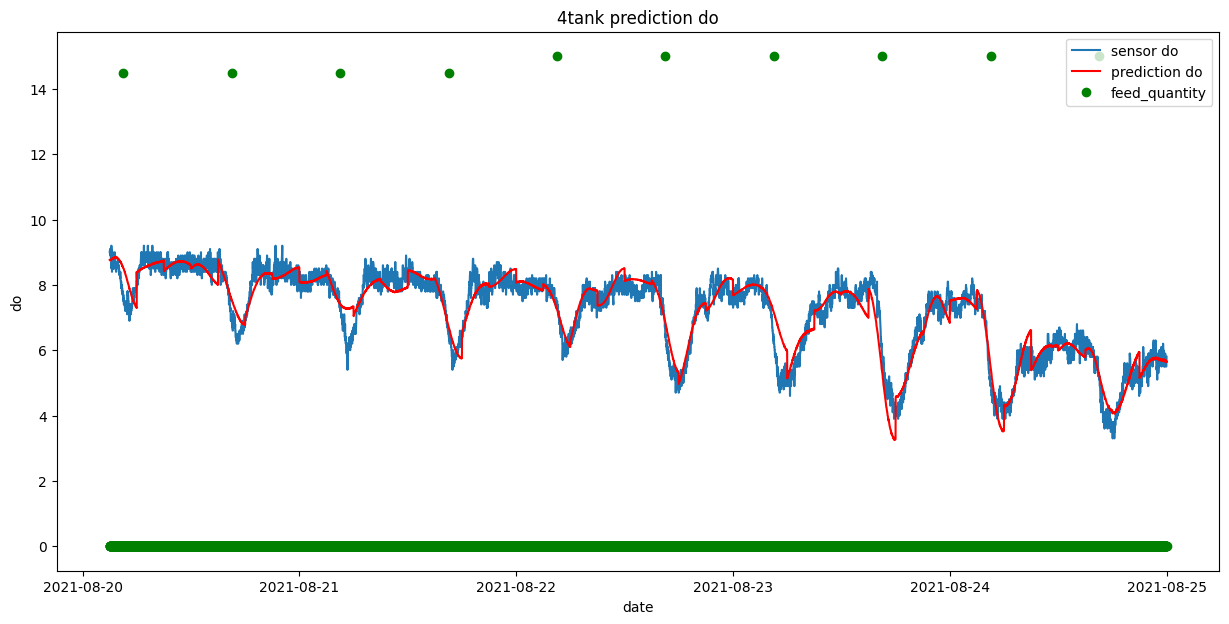

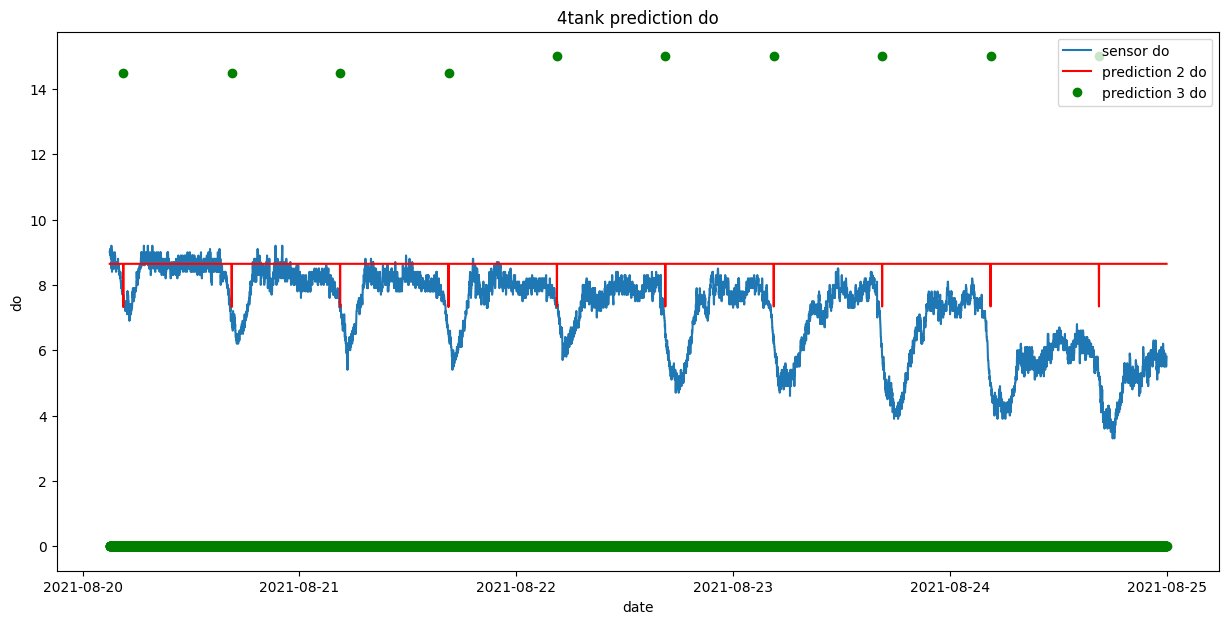

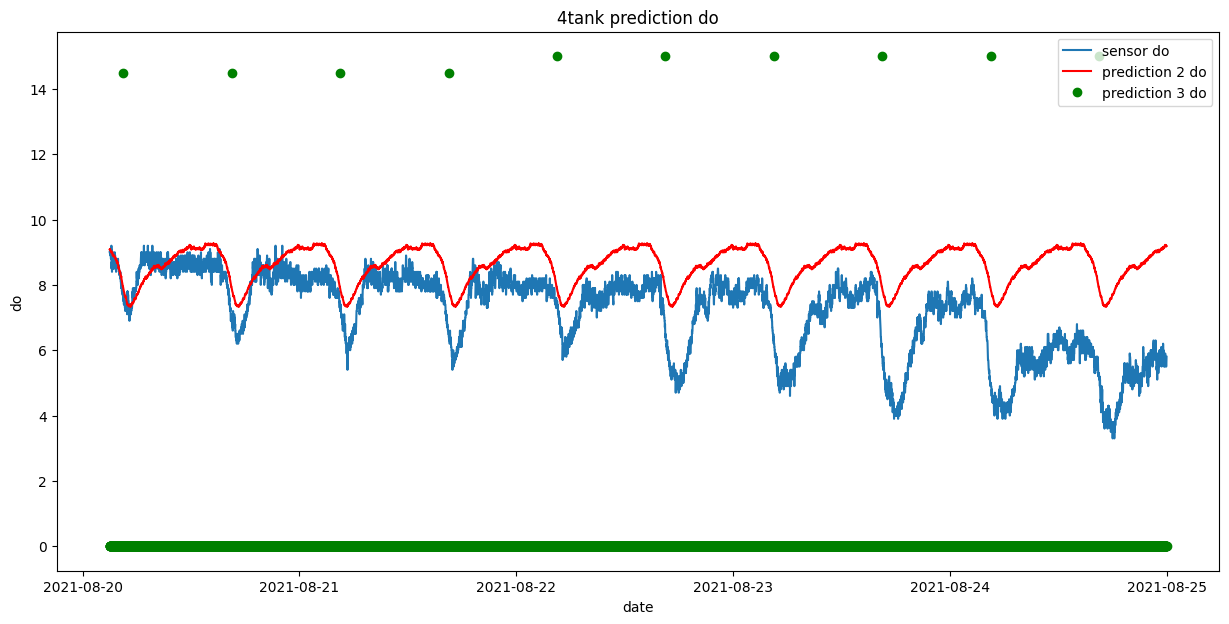

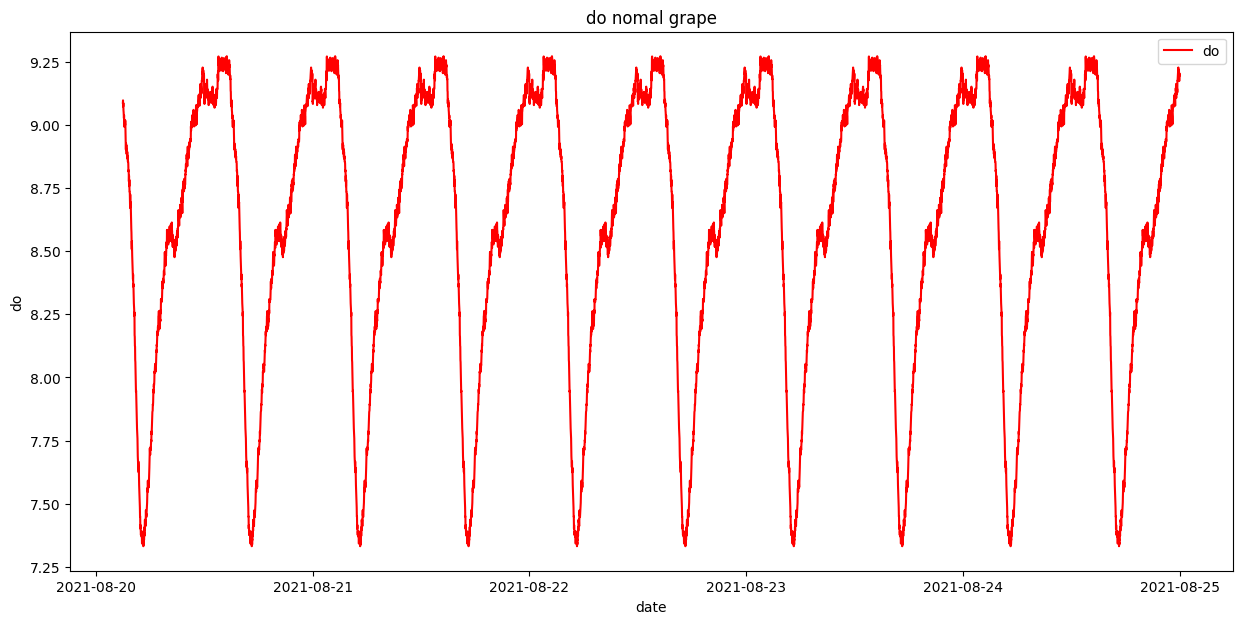

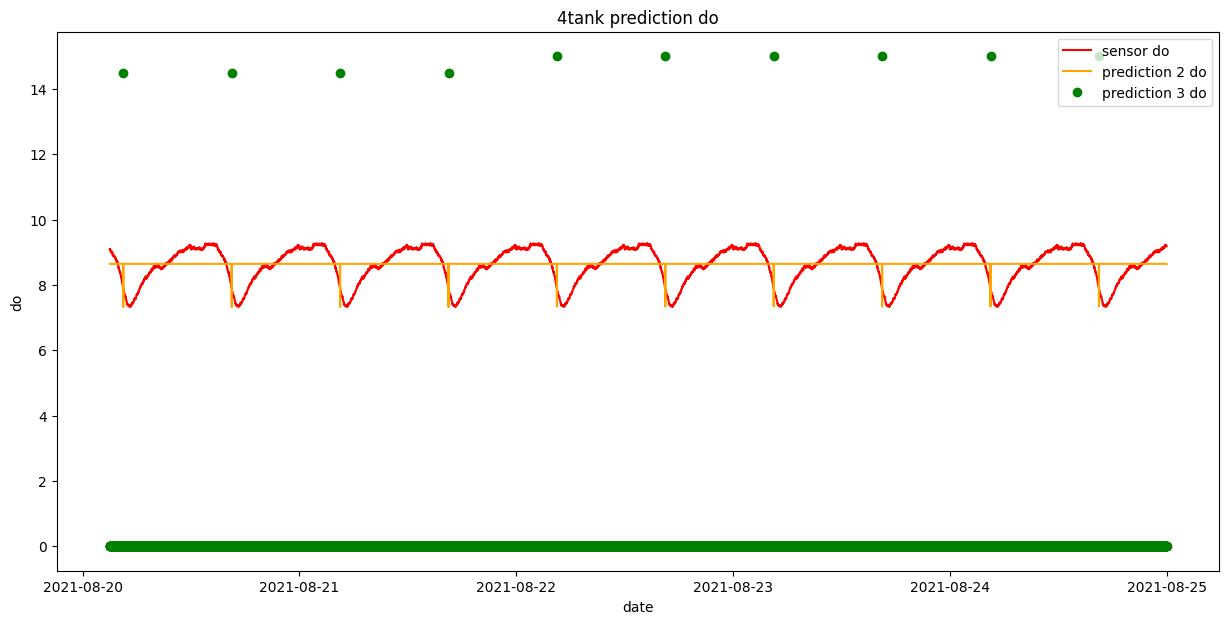

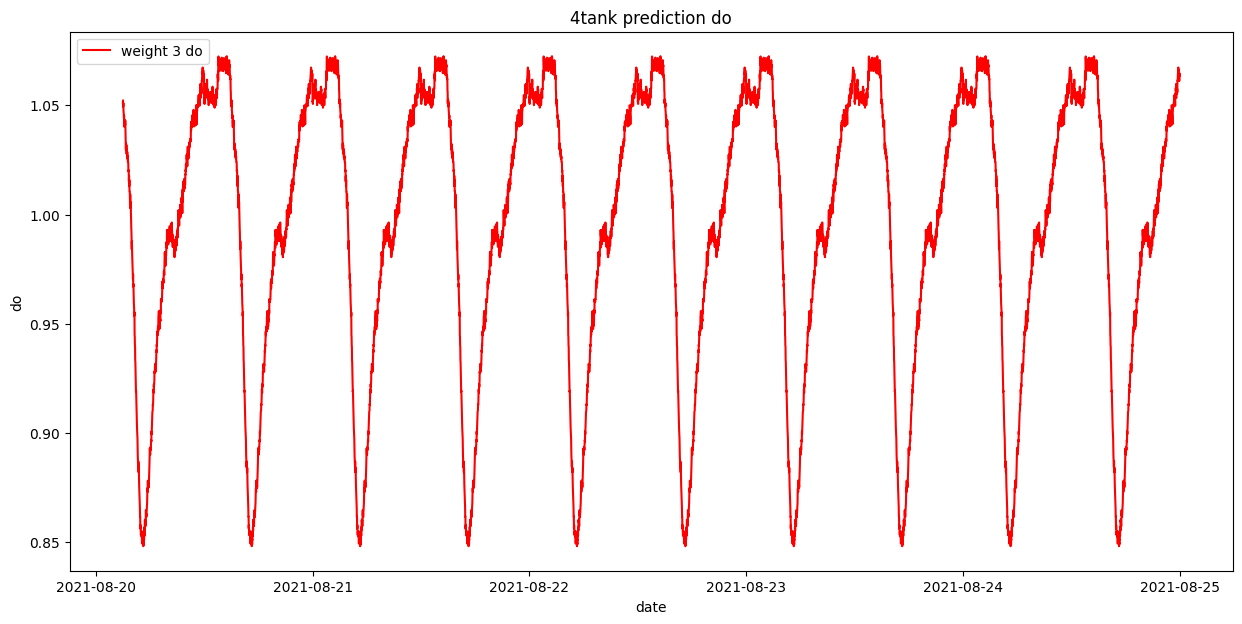

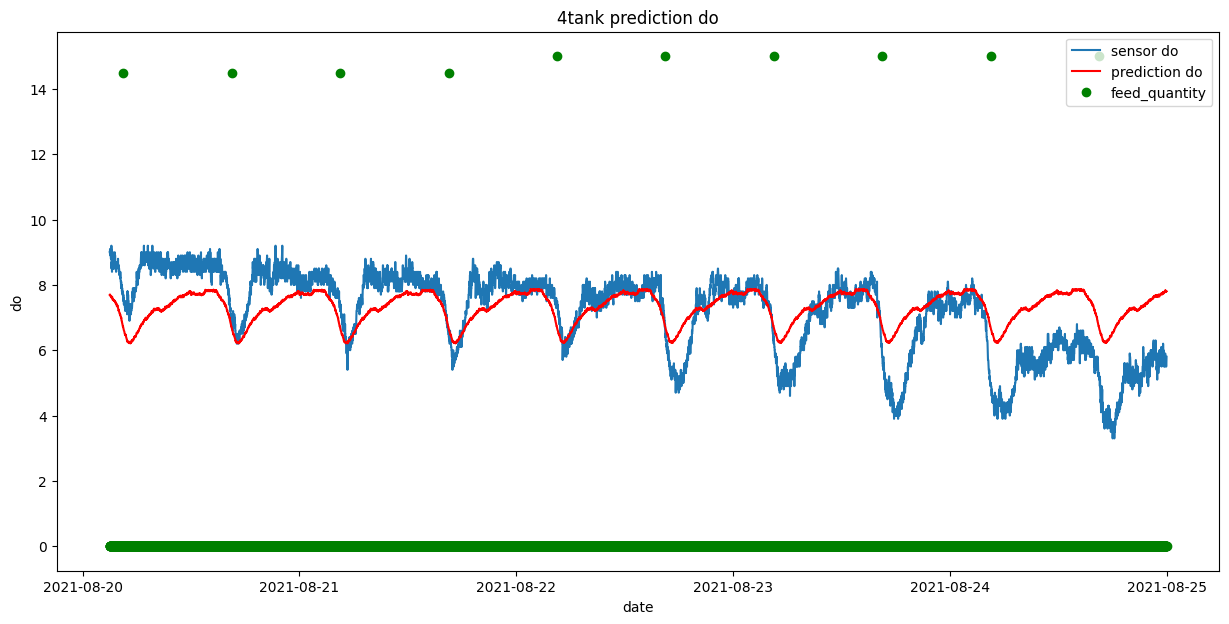

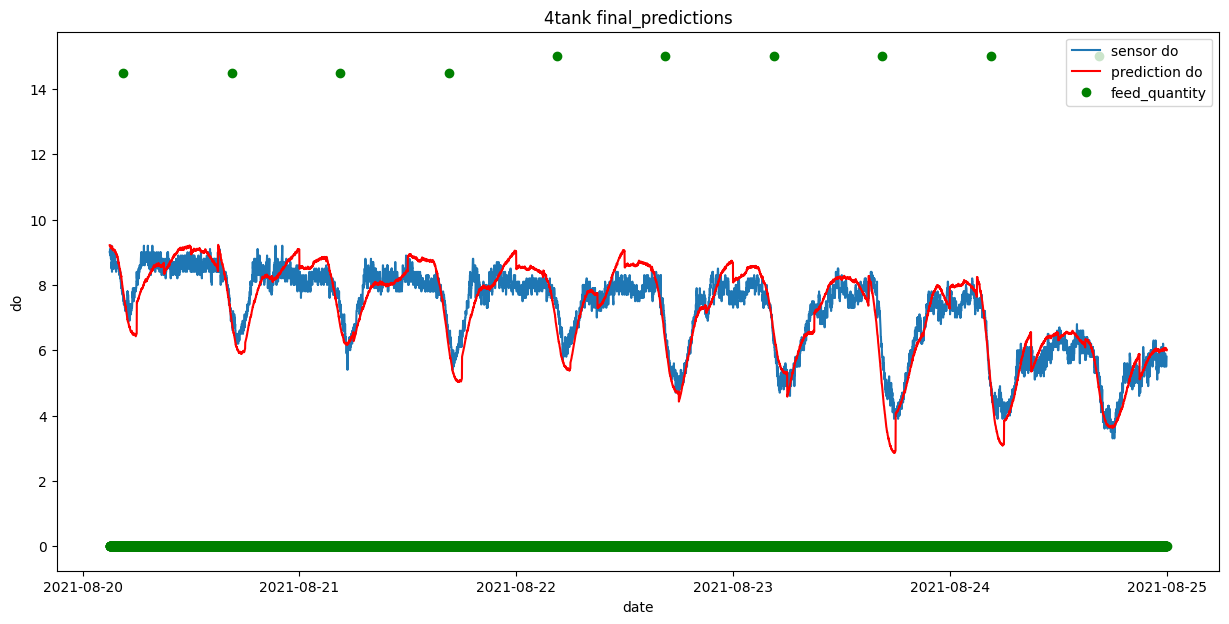

Euclidean Distance
 33.842  →  44.686
Cosine Similarity
 0.998  →  0.997
Correlation Coefficient
 0.052  →  0.065
Mean Squared Error
 0.163  →  0.284
Mean Absolute Error
 0.305  →  0.432
Correlation Coefficient
 0.948  →  0.935


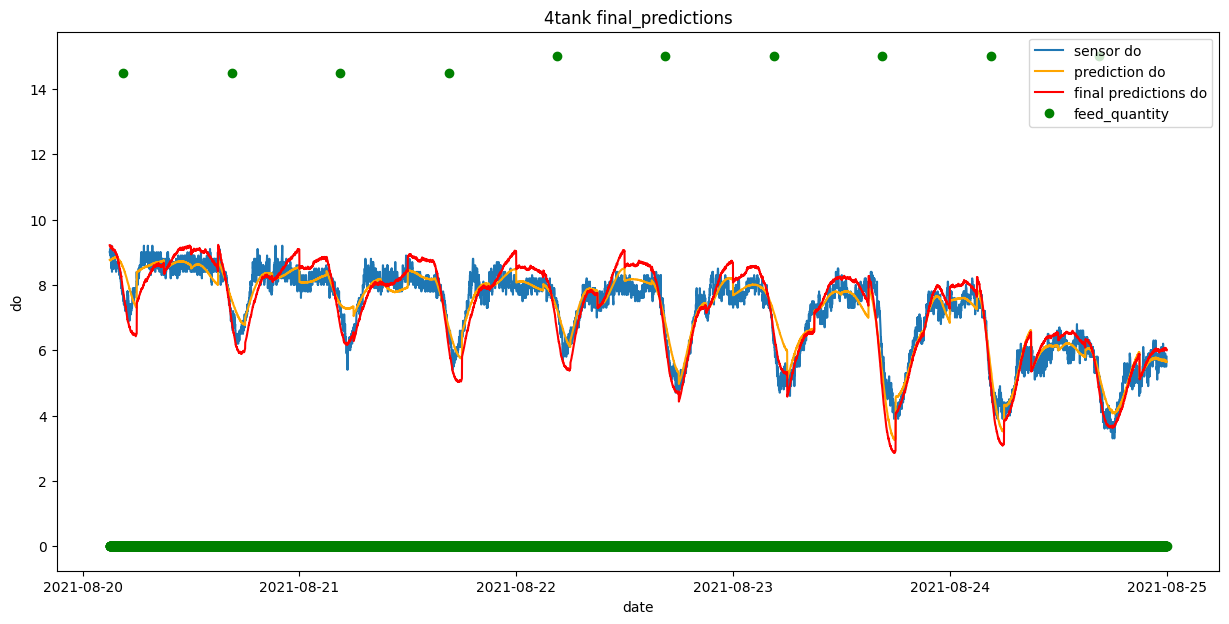

In [55]:
y_date = japonica_validation_features_y.loc['2021-08-20 03:00':'2021-08-24 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-20 00:00':'2021-08-24 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-20 03:00':'2021-08-24 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 97ms/step


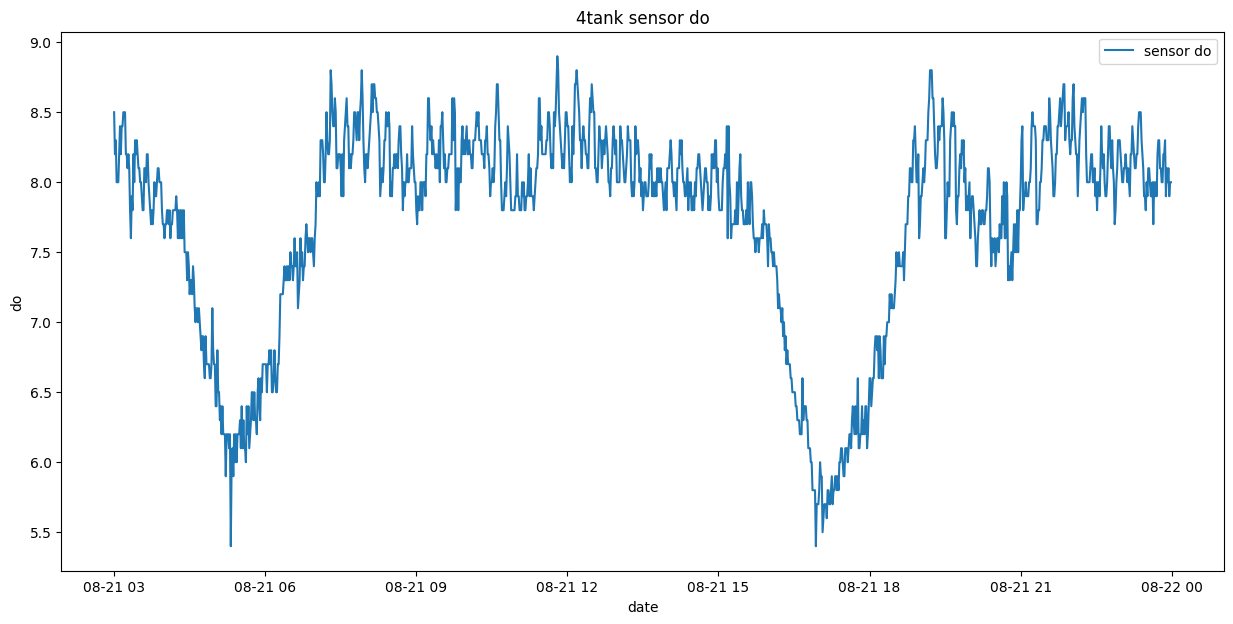

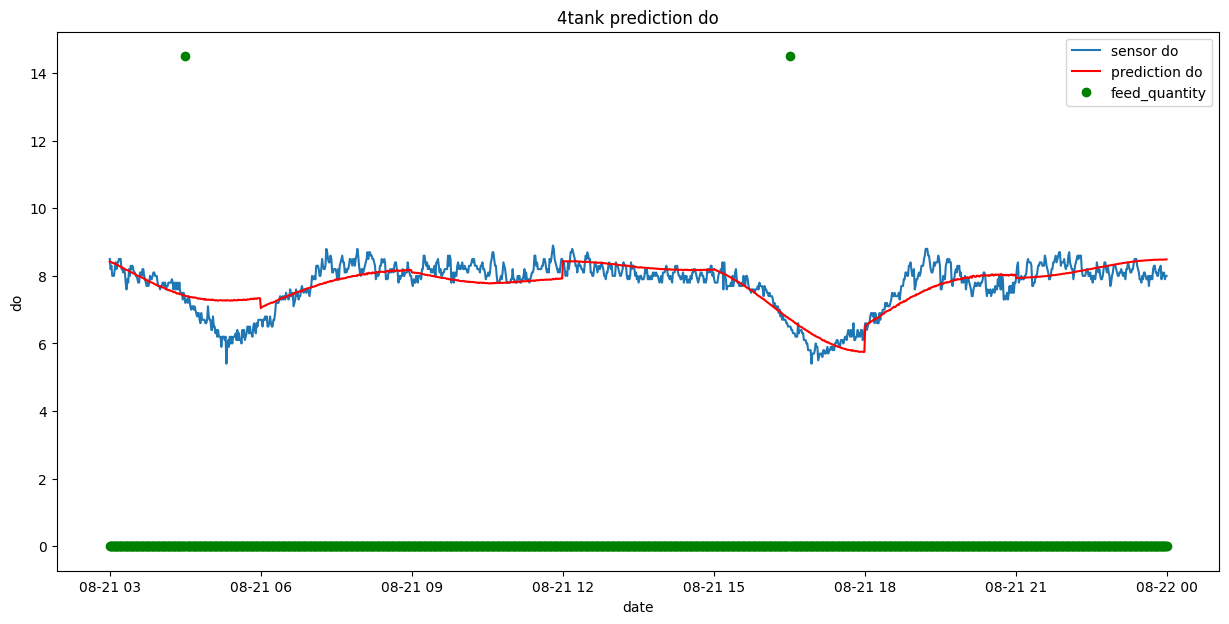

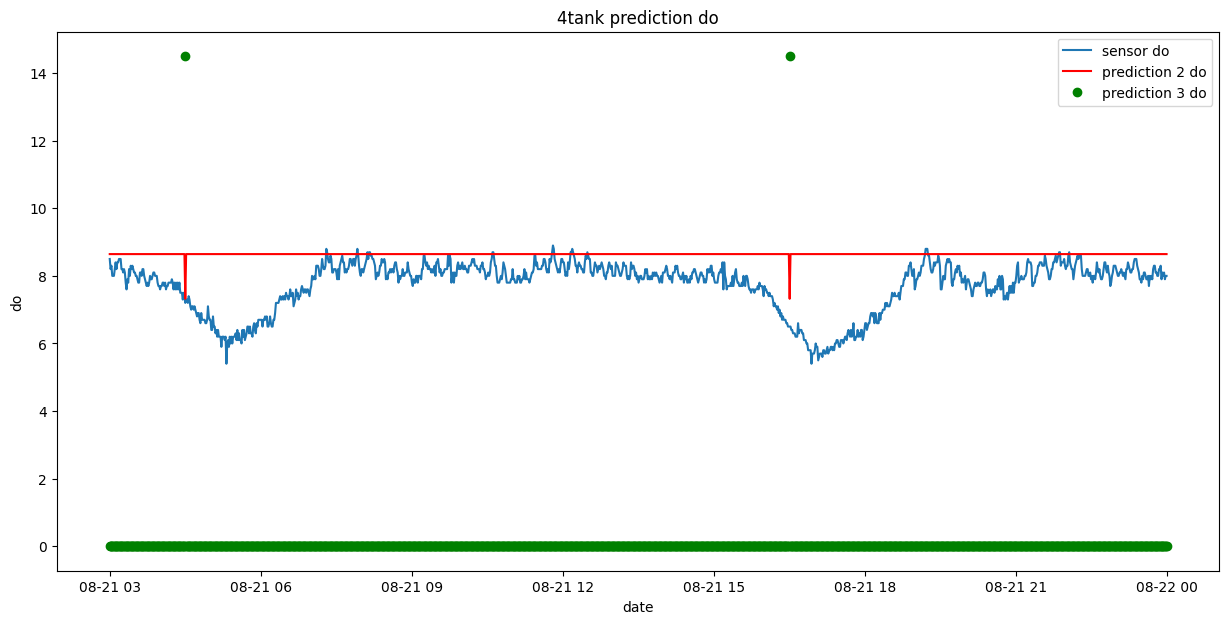

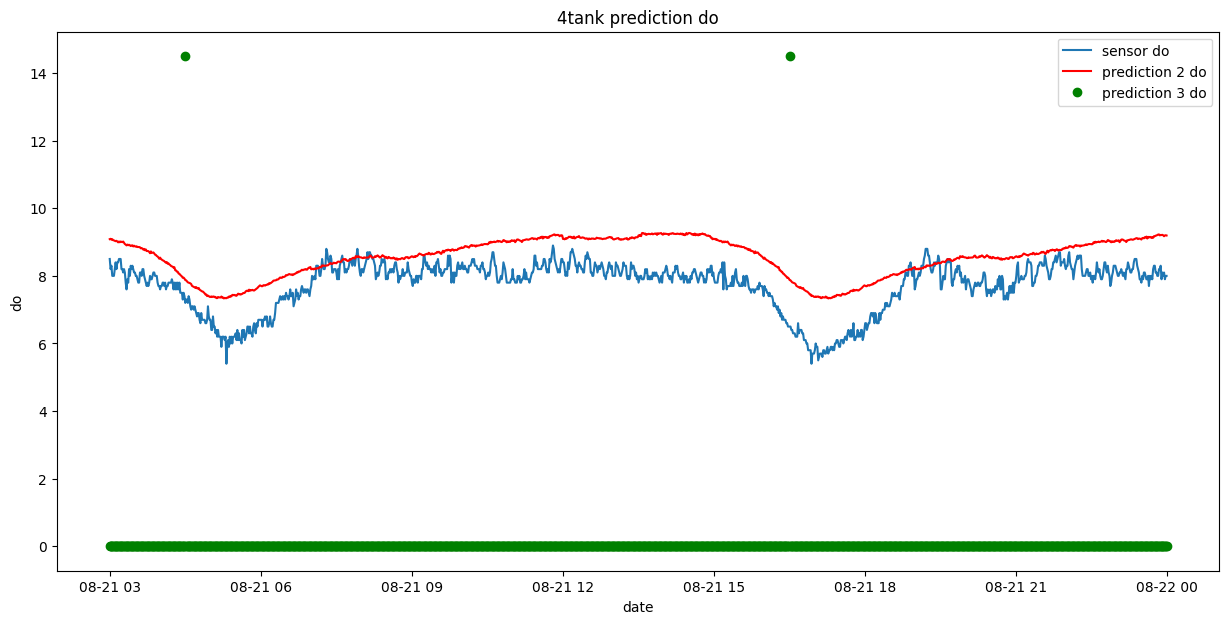

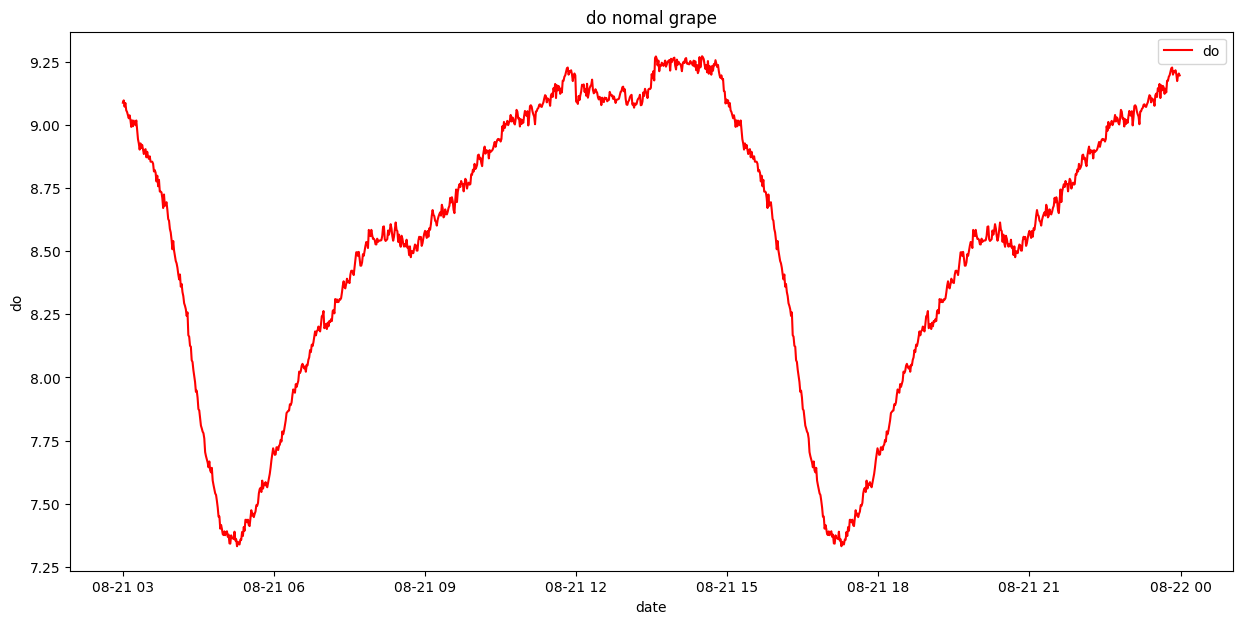

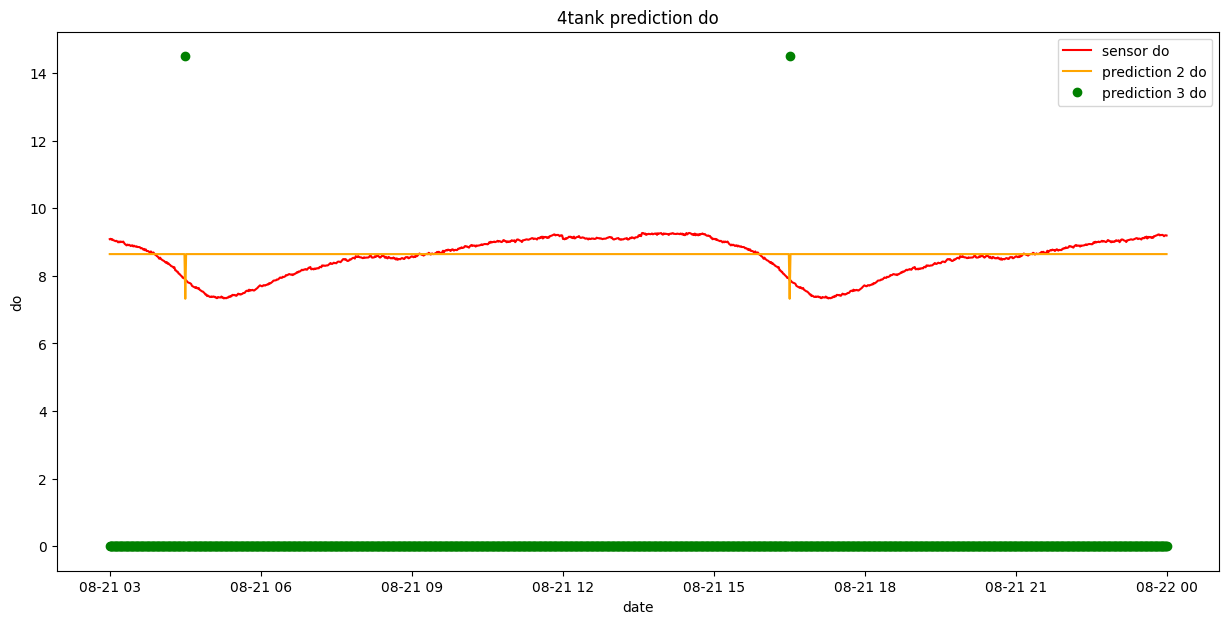

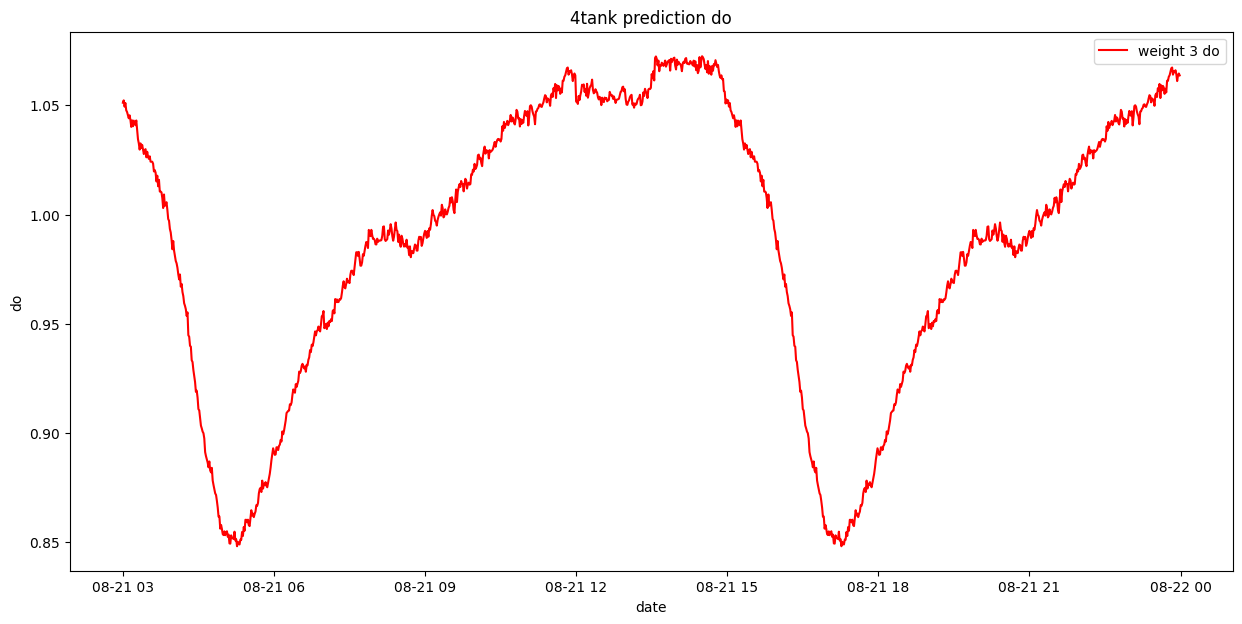

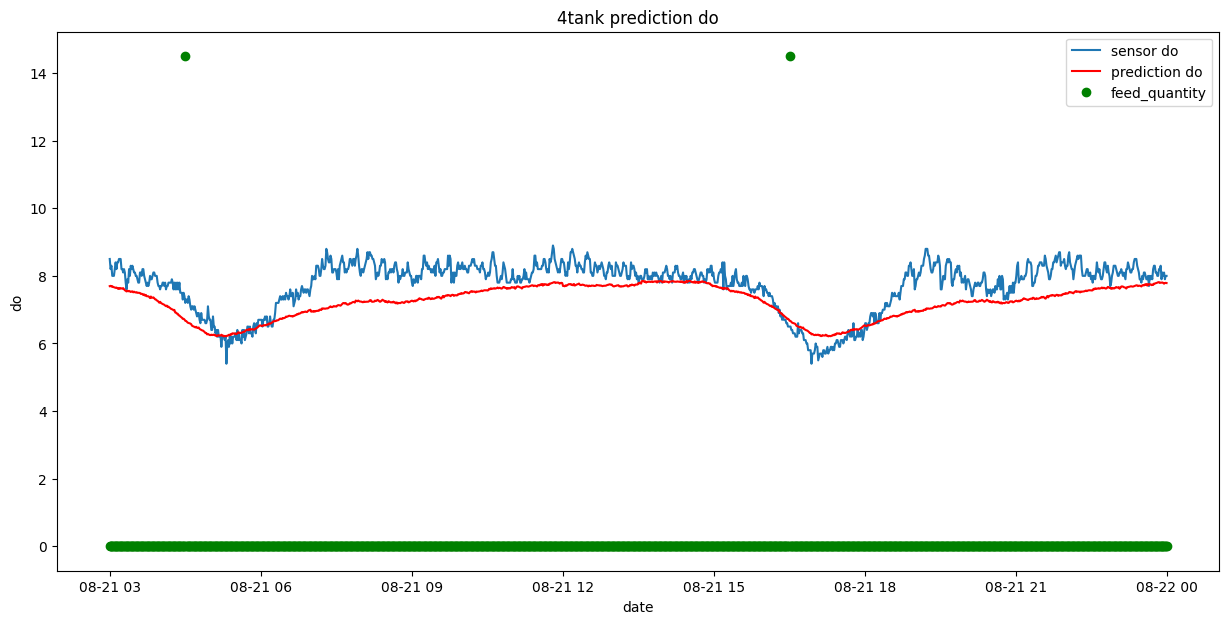

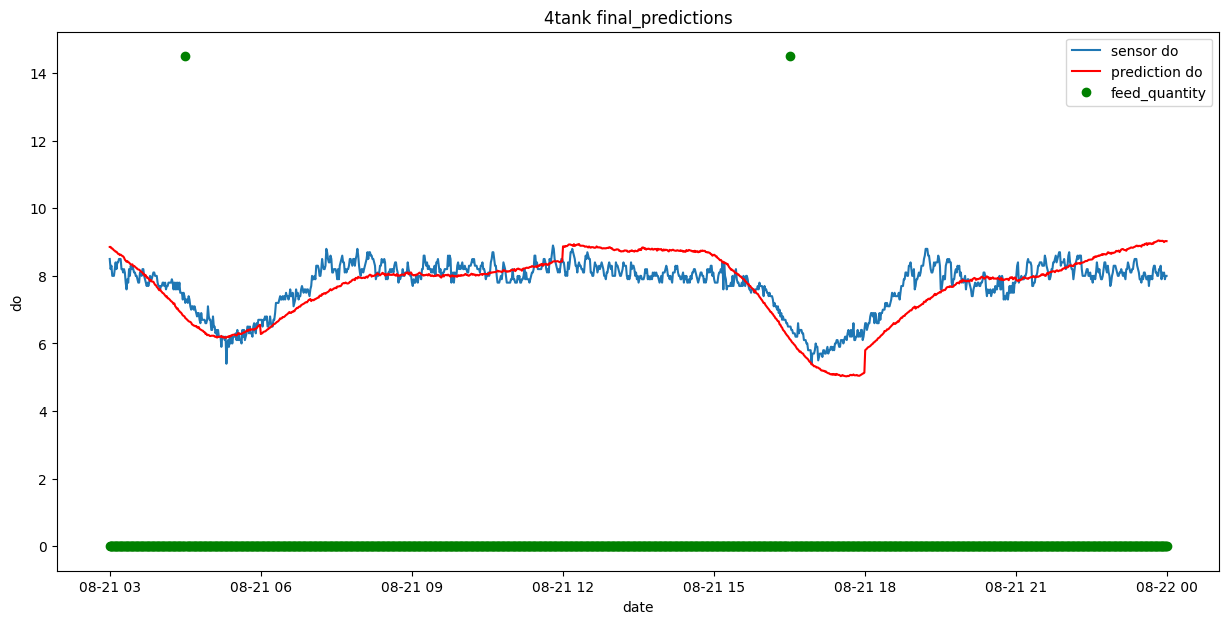

Euclidean Distance
 14.563  →  19.774
Cosine Similarity
 0.999  →  0.997
Correlation Coefficient
 0.171  →  0.147
Mean Squared Error
 0.168  →  0.310
Mean Absolute Error
 0.316  →  0.461
Correlation Coefficient
 0.829  →  0.853


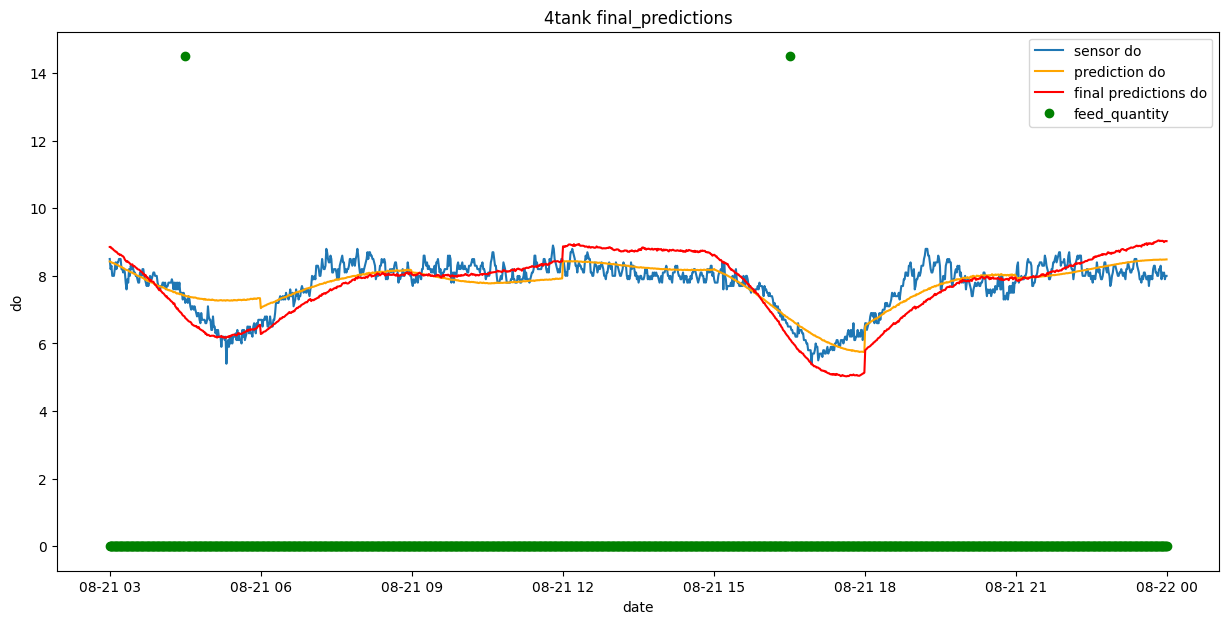

C:\Users\rladn\AppData\Local\Temp\ipykernel_19868\3768752340.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_a.at['2021-08-21 08:00', 'feed_quantity'] = 6
C:\Users\rladn\AppData\Local\Temp\ipykernel_19868\3768752340.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 6


nCar: 1260 nVar: 1
nCar: 7 nVar: 9
nCar: 7 nVar: 9
1/1 [==============================] - 0s 99ms/step


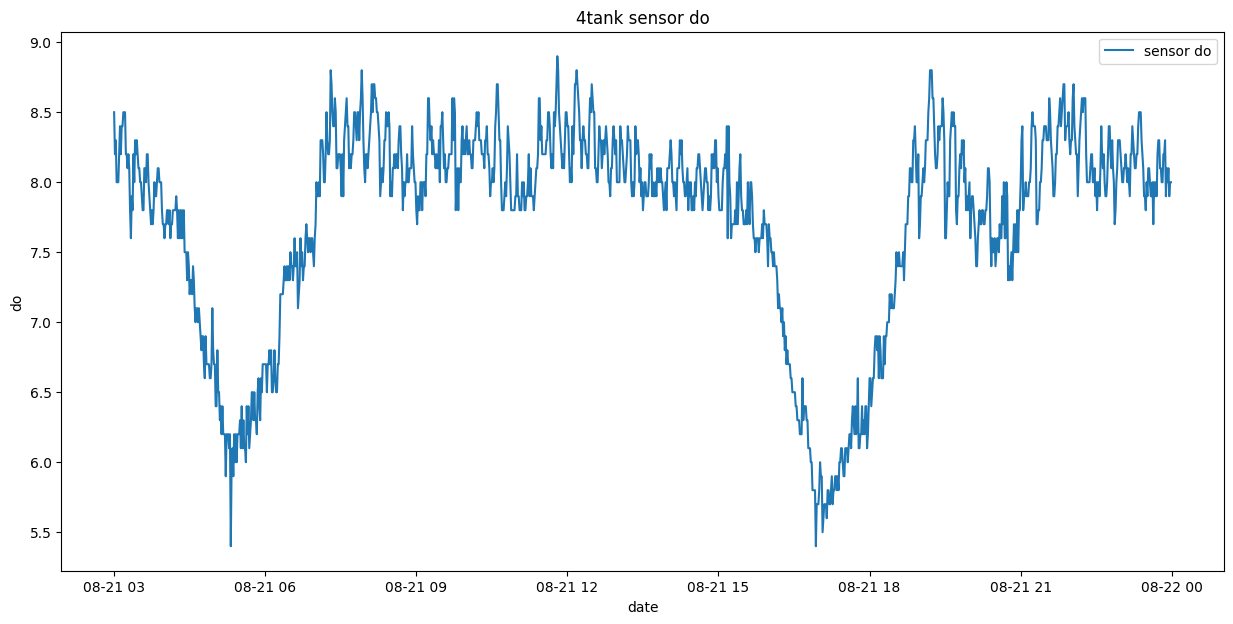

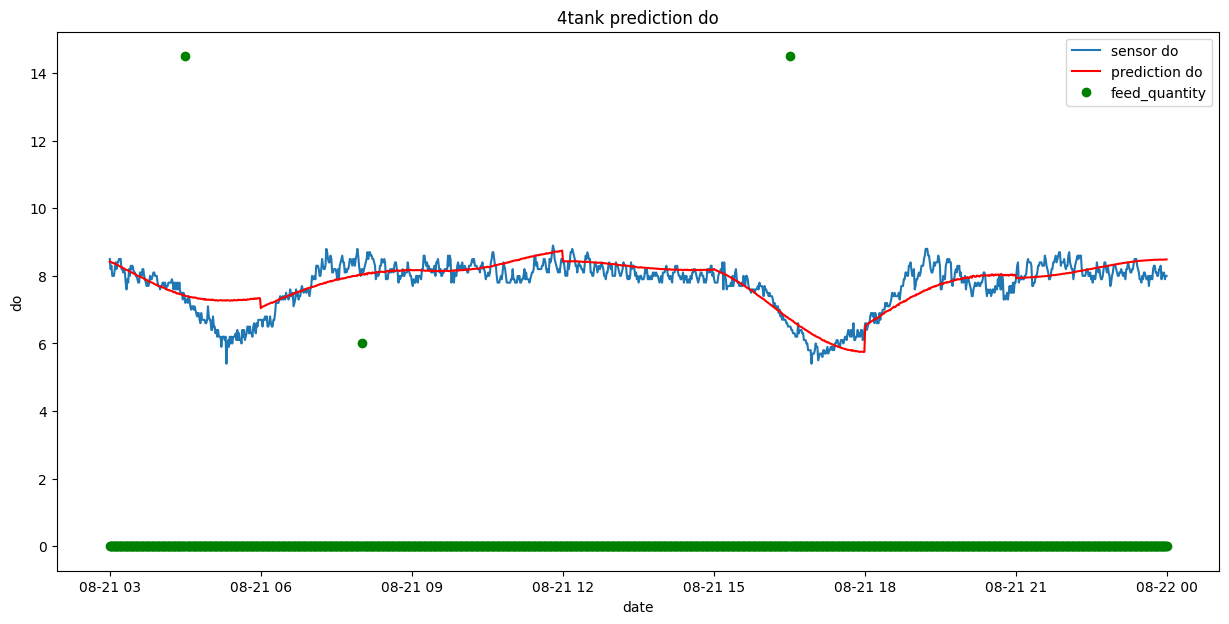

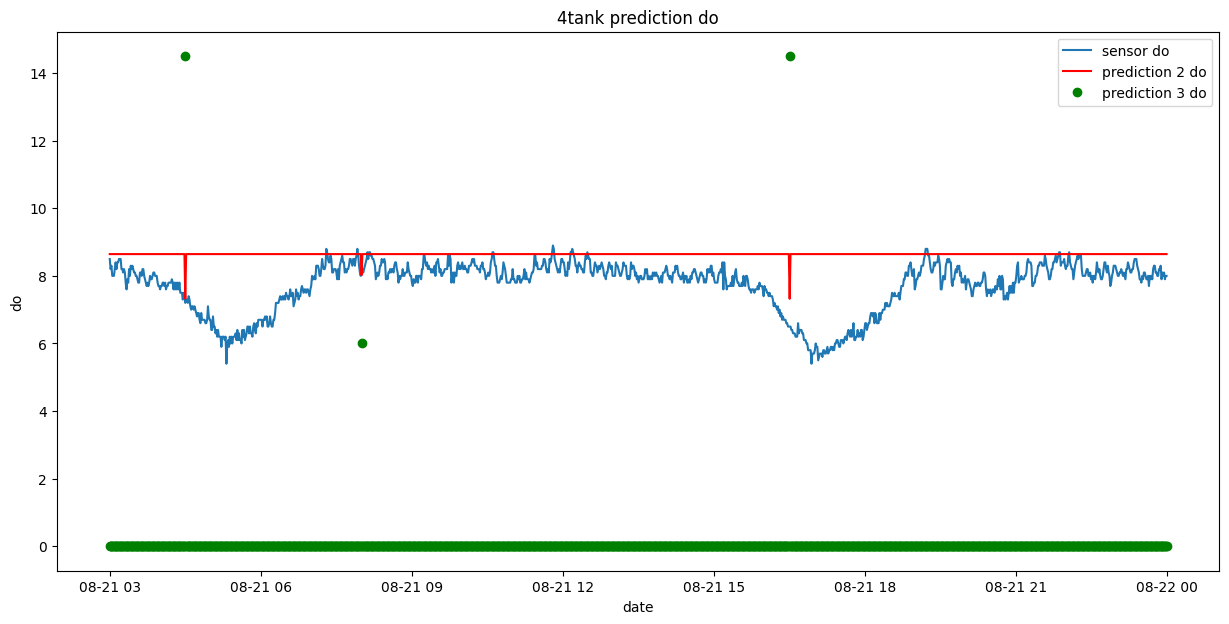

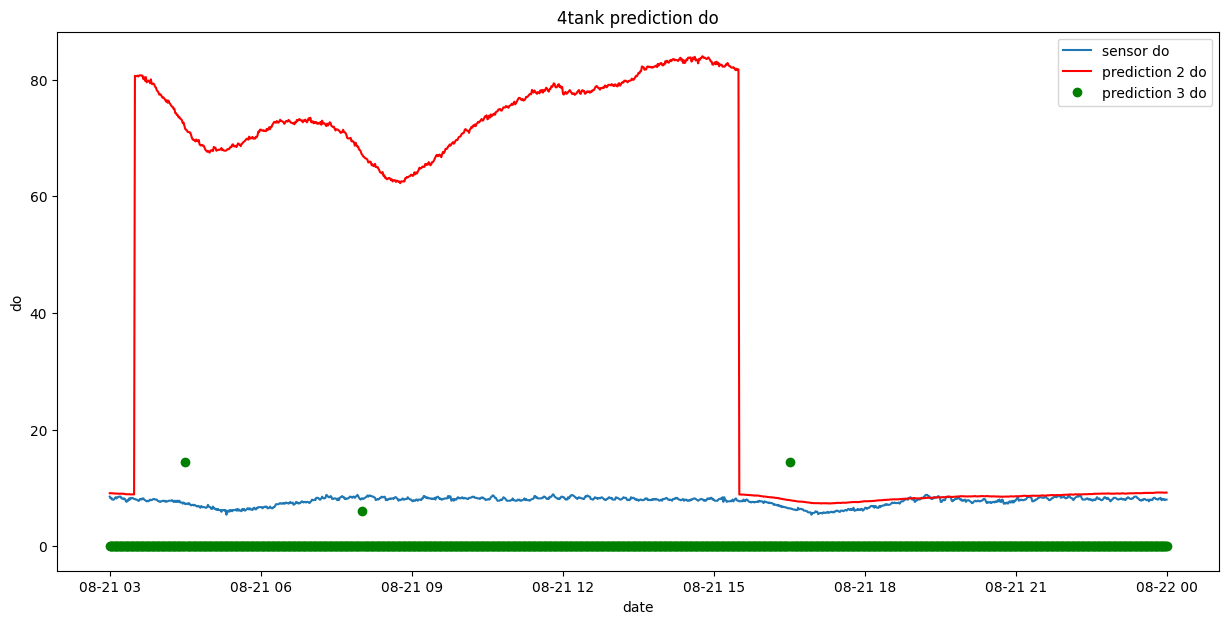

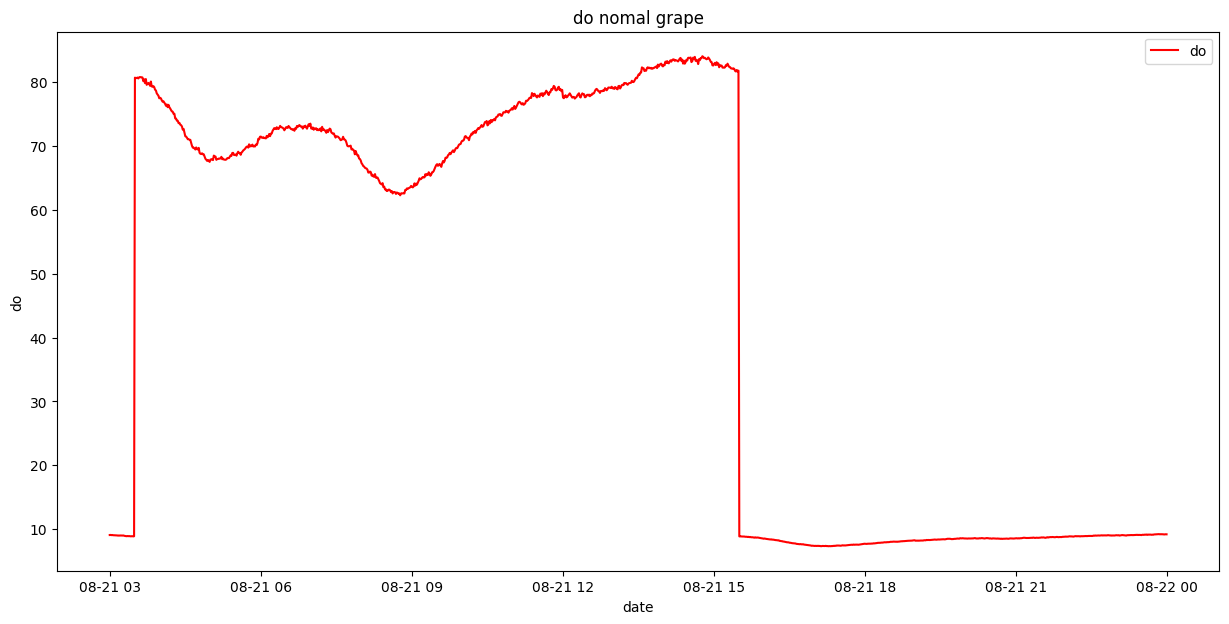

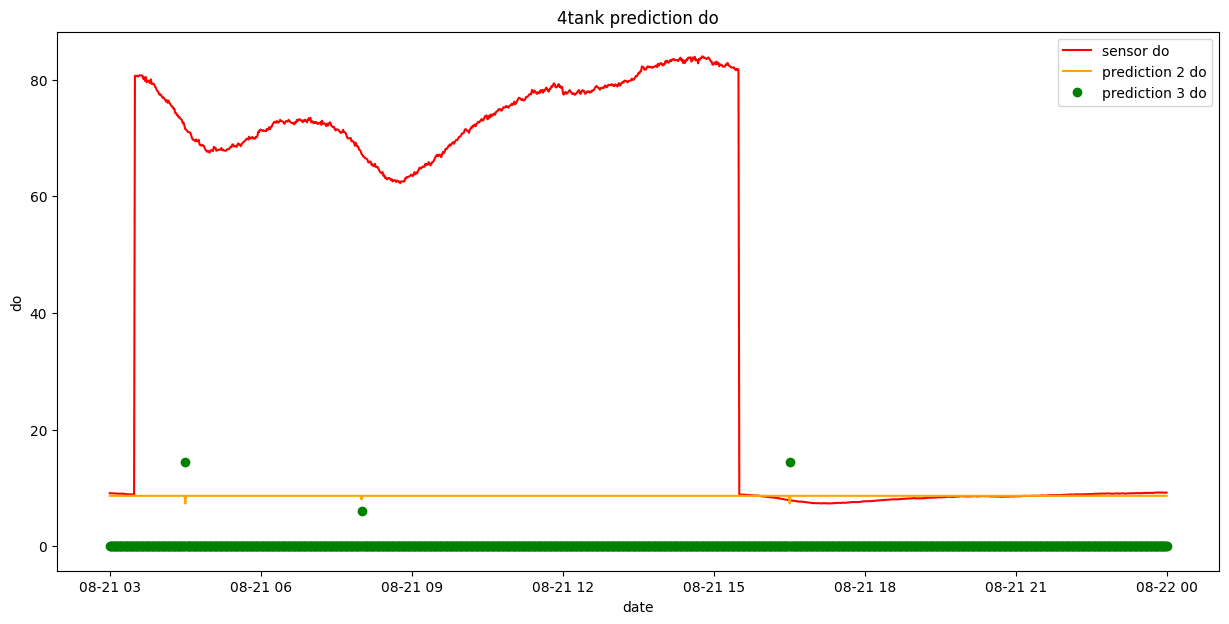

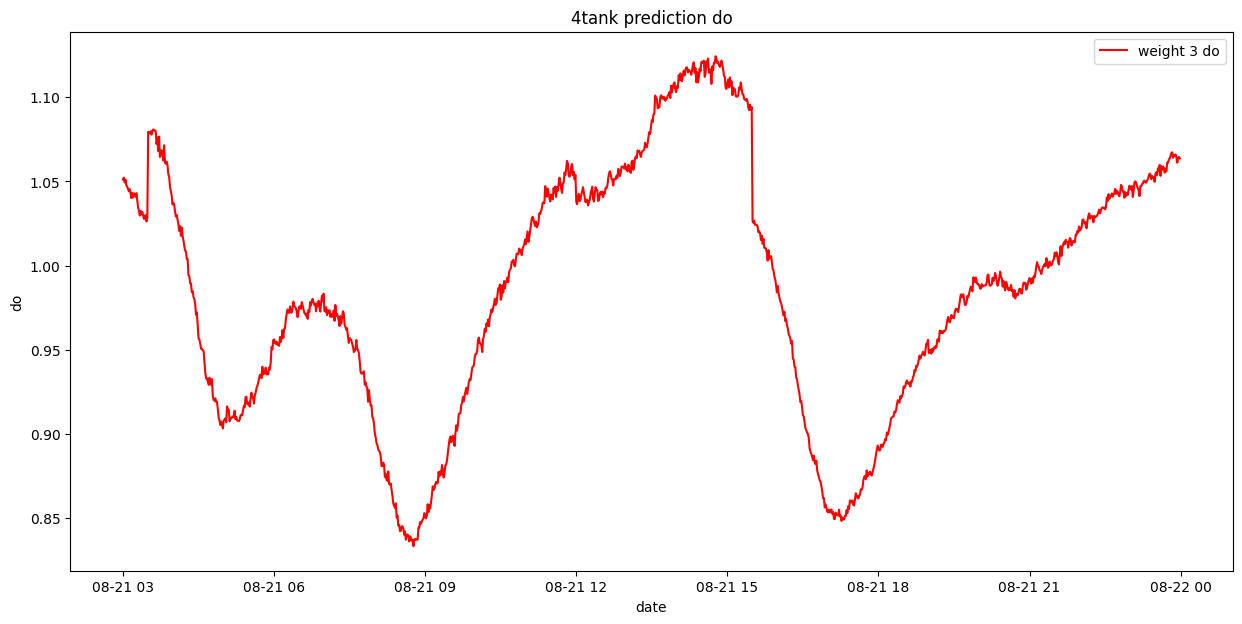

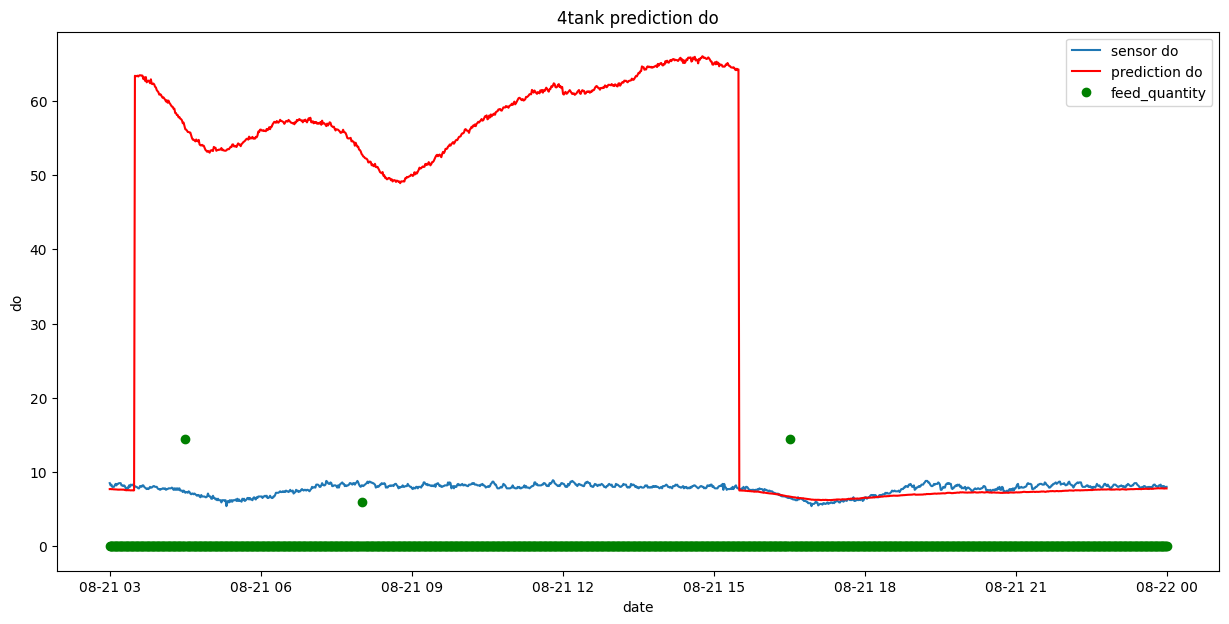

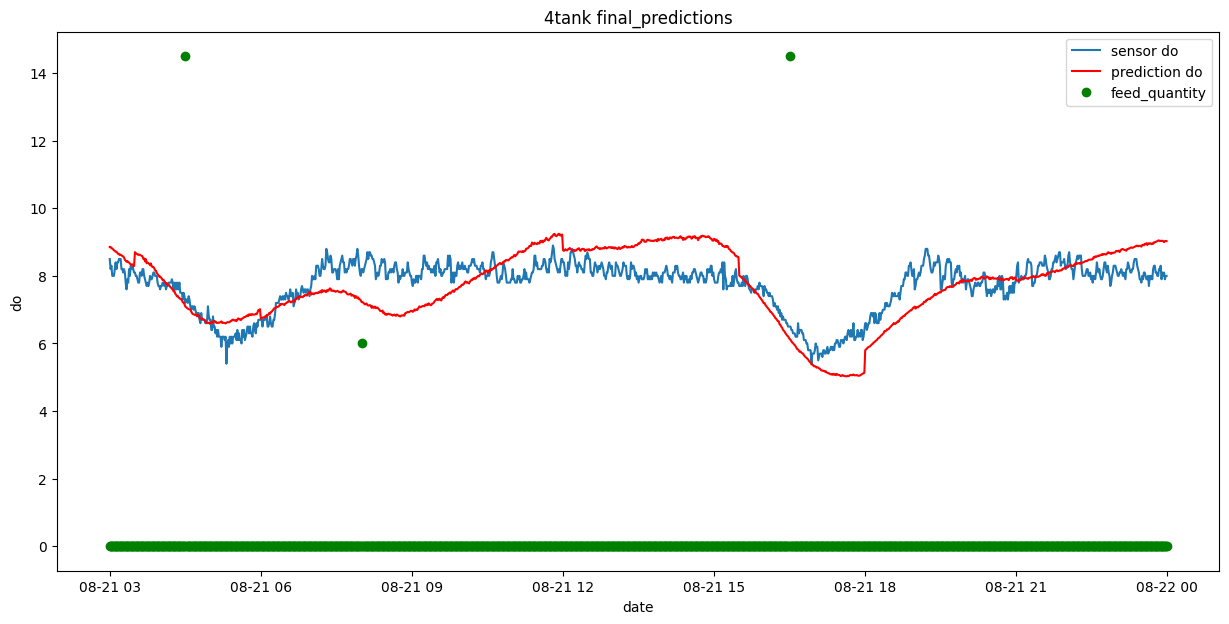

Euclidean Distance
 14.384  →  25.589
Cosine Similarity
 0.999  →  0.996
Correlation Coefficient
 0.160  →  0.261
Mean Squared Error
 0.164  →  0.520
Mean Absolute Error
 0.311  →  0.612
Correlation Coefficient
 0.840  →  0.739


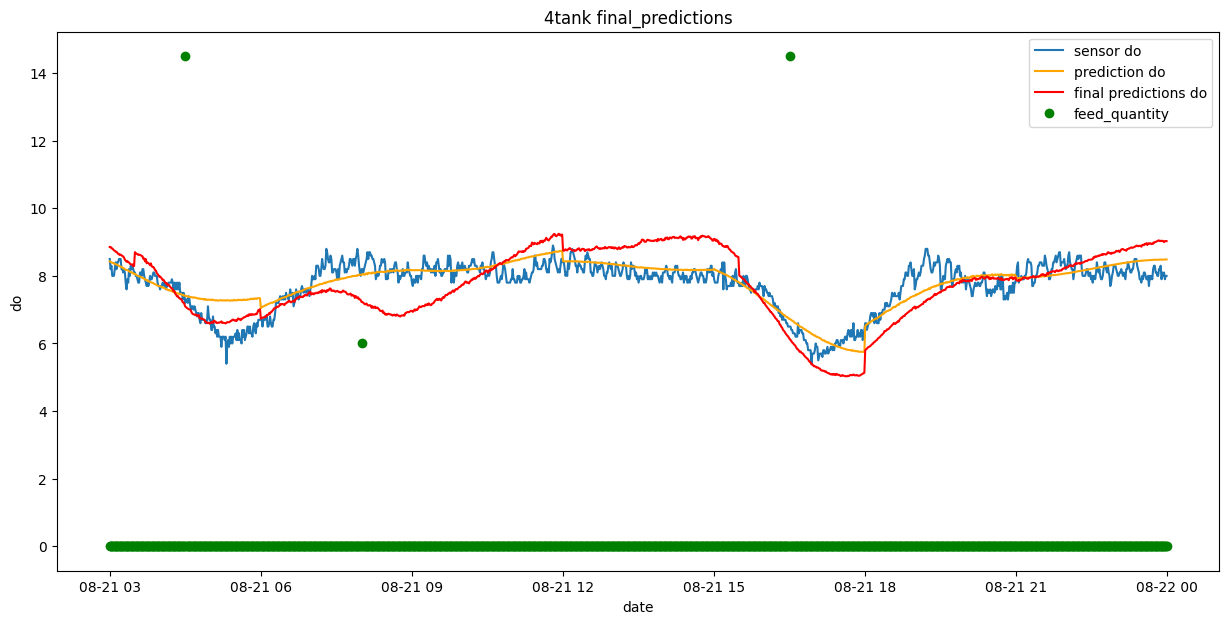

In [56]:
y_date = japonica_validation_features_y.loc['2021-08-21 03:00':'2021-08-21 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-21 00:00':'2021-08-21 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-21 03:00':'2021-08-21 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)

japonica_validation_features_X_a.at['2021-08-21 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-08-21 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-08-21 03:00':'2021-08-21 23:59']

y_test = y_date[['do_mg']]

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-08-21 00:00':'2021-08-21 20:59']
X_test2 = japonica_validation_features_X_b.loc['2021-08-21 03:00':'2021-08-21 23:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

feed = X_test2[['feed_quantity']]
feed = np.asarray(feed, dtype=np.float64)
feed = feed.reshape(-1)

grapeNEva5(y_test, X_test_reshape1, feed)